In [1]:
import numpy as np

In [2]:
from numpy import sqrt
import pandas as pd

Text(0.5, 0.98, 'Actual change points in temperature (sensor 3)')

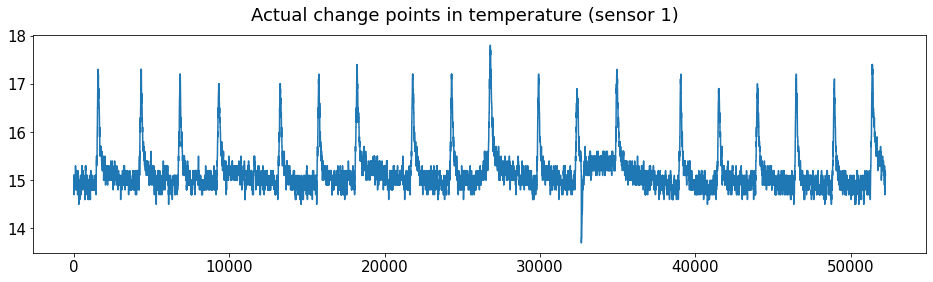

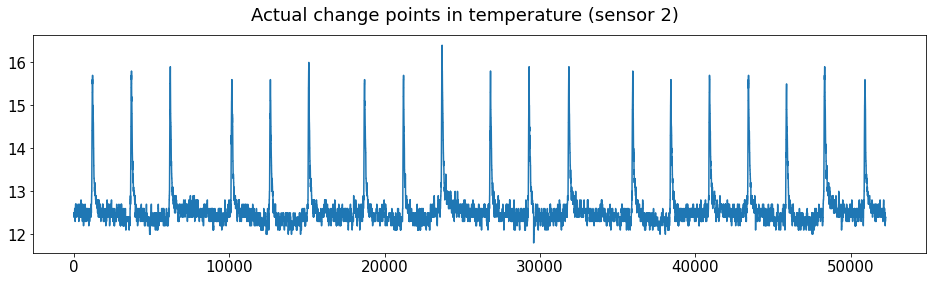

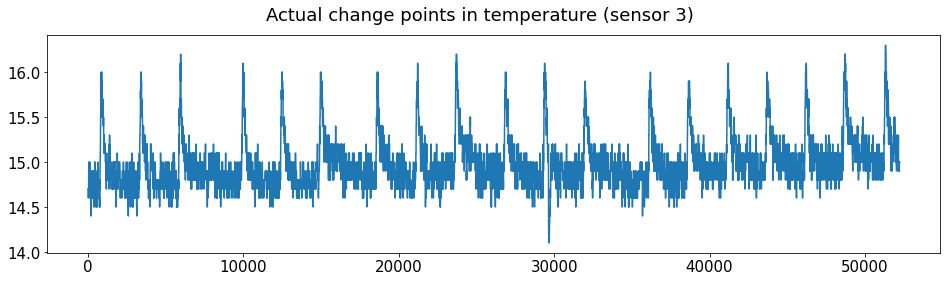

In [16]:
Temperature = pd.read_excel(r'C:\Users\Subhadeep\Documents\Datasets\Experiment 2\IoT data aggregation\Temperature.xlsx',sheet_name='Sheet1')
#Temperature1 = Temperature[0:8640] 
#Temperature1 = Temperature[0:8640] 
#Temperature3 = Temperature[17280:25920] 
#Temperature5 = Temperature[34560:43200] 
#Temperature7 = Temperature[51840:60480] 
#Temperature9 = Temperature[61920:77760] 
#Temperature11 = Temperature[86400:95040] 
#Temperature13 = Temperature[103680:112320] 
#Temperature15 = Temperature[120960:129600] 
Temperature1_week = Temperature[8640:69120] 
Temperature2_week = Temperature[69121:129600] 
Humidity = pd.read_excel(r'C:\Users\Subhadeep\Documents\Datasets\Experiment 2\IoT data aggregation\Humidity.xlsx',sheet_name='HUMIDITY')
Humidity1_week = Humidity[8640:69120] 
Humidity2_week = Humidity[69121:129600] 

Temperature_2_TOP = Temperature2_week['Top layer']
Temperature_2_BOTTOM = Temperature2_week['Below layer']
Temperature_2_MIDDLE = Temperature2_week['Middle Layer']

Humidity_2_TOP = Humidity2_week['Top layer'] 
Humidity_2_BOTTOM = Humidity2_week['Below layer']
Humidity_2_MIDDLE = Humidity2_week['Middle layer']


ts1 = []
tsA = Temperature_2_TOP
ts1 = np.append(ts1,tsA,axis=0)
plt.figure(figsize=(16,4))
plt.plot(ts1)
plt.suptitle('Actual change points in temperature (sensor 1)')

ts2 = []
tsB = Temperature_2_BOTTOM
ts2 = np.append(ts2,tsB,axis=0)   
plt.figure(figsize=(16,4))
plt.plot(ts2)
plt.suptitle('Actual change points in temperature (sensor 2)')

ts3 = []
tsC = Temperature_2_MIDDLE 
ts3 = np.append(ts3,tsC, axis=0)   
plt.figure(figsize=(16,4))
plt.plot(ts3)
plt.suptitle('Actual change points in temperature (sensor 3)')

In [11]:
from scipy import stats
from scipy.stats import norm
from scipy.special import logsumexp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import random
import changefinder #Detect change points using SDVAR method
%matplotlib inline
# setting font sizeto 30
plt.rcParams.update({'font.size': 15})

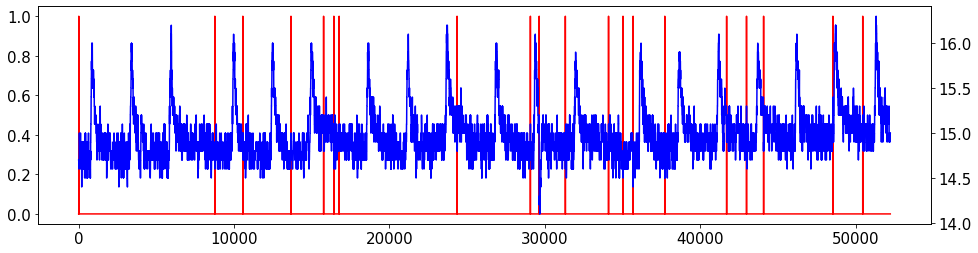

In [22]:
data=ts3
ret = []
cf = changefinder.ChangeFinder(r=0.02, order=1, smooth=6)

#Setting the forgetting factor
for i in data:
    score = cf.update(i)
    ret.append(score>30)

# Plot
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax2.plot(data,'b')
ax.plot(ret, 'r')
plt.show()

In [23]:
ts_change_loc1 = pd.Series(ret)
ts_change_loc1 = ts_change_loc1.index
ts_change_loc1

RangeIndex(start=0, stop=52240, step=1)

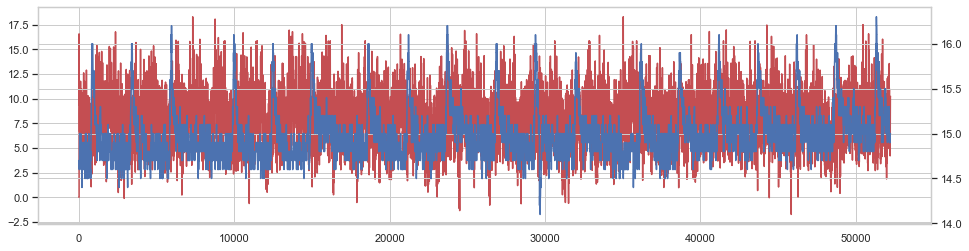

In [81]:
# -*- coding: utf-8 -*-
import statsmodels.api as sm
import numpy as np
import scipy as sp
import math


def LevinsonDurbin(r, lpcOrder):
    """
    from http://aidiary.hatenablog.com/entry/20120415/1334458954
    """
    a = np.zeros(lpcOrder + 1, dtype=np.float64)
    e = np.zeros(lpcOrder + 1, dtype=np.float64)

    a[0] = 1.0
    a[1] = - r[1] / r[0]
    e[1] = r[0] + r[1] * a[1]
    lam = - r[1] / r[0]

    for k in range(1, lpcOrder):
        lam = 0.0
        for j in range(k + 1):
            lam -= a[j] * r[k + 1 - j]
        lam /= e[k]

        U = [1]
        U.extend([a[i] for i in range(1, k + 1)])
        U.append(0)

        V = [0]
        V.extend([a[i] for i in range(k, 0, -1)])
        V.append(1)

        a = np.array(U) + lam * np.array(V)
        e[k + 1] = e[k] * (1.0 - lam * lam)

    return a, e[-1]


class _SDAR_1Dim(object):
    def __init__(self, r, order):
        self._r = r
        self._mu = np.random.random()
        self._sigma = np.random.random()
        self._order = order
        self._c = np.random.random(self._order+1) / 100.0

    def update(self, x, term):
        assert len(term) >= self._order, "term must be order or more"
        term = np.array(term)
        self._mu = (1.0 - self._r) * self._mu + self._r * x
        for i in range(1, self._order + 1):
            self._c[i] = (1 - self._r) * self._c[i] + self._r * (x - self._mu) * (term[-i] - self._mu)
        self._c[0] = (1-self._r)*self._c[0]+self._r * (x-self._mu)*(x-self._mu)
        what, e = LevinsonDurbin(self._c, self._order)
        xhat = np.dot(-what[1:], (term[::-1] - self._mu))+self._mu
        self._sigma = (1-self._r)*self._sigma + self._r * (x-xhat) * (x-xhat)
        return -math.log(math.exp(-0.5*(x-xhat)**2/self._sigma)/((2 * math.pi)**0.5*self._sigma**0.5)), xhat


class _ChangeFinderAbstract(object):
    def _add_one(self, one, ts, size):
        ts.append(one)
        if len(ts) == size+1:
            ts.pop(0)

    def _smoothing(self, ts):
        return sum(ts)/float(len(ts))


class ChangeFinder(_ChangeFinderAbstract):
    def __init__(self, r=0.5, order=1, smooth=7):
        assert order > 0, "order must be 1 or more."
        assert smooth > 2, "term must be 3 or more."
        self._smooth = smooth
        self._smooth2 = int(round(self._smooth/2.0))
        self._order = order
        self._r = r
        self._ts = []
        self._first_scores = []
        self._smoothed_scores = []
        self._second_scores = []
        self._sdar_first = _SDAR_1Dim(r, self._order)
        self._sdar_second = _SDAR_1Dim(r, self._order)

    def update(self, x):
        score = 0
        predict = x
        predict2 = 0
        if len(self._ts) == self._order:  # 第一段学習
            score, predict = self._sdar_first.update(x, self._ts)
            self._add_one(score, self._first_scores, self._smooth)
        self._add_one(x, self._ts, self._order)
        second_target = None
        if len(self._first_scores) == self._smooth:  # 平滑化
            second_target = self._smoothing(self._first_scores)
        if second_target and len(self._smoothed_scores) == self._order:  # 第二段学習
            score, predict2 = self._sdar_second.update(second_target, self._smoothed_scores)
            self._add_one(score,
                          self._second_scores, self._smooth2)
        if second_target:
            self._add_one(second_target, self._smoothed_scores, self._order)
        if len(self._second_scores) == self._smooth2:
            return self._smoothing(self._second_scores), predict
        else:
            return 0.0, predict


class ChangeFinderARIMA(_ChangeFinderAbstract):
    def __init__(self, term=30, smooth=7, order=(1, 0, 0)):
        assert smooth > 2, "term must be 3 or more."
        assert term > smooth, "term must be more than smooth"

        self._term = term
        self._smooth = smooth
        self._smooth2 = int(round(self._smooth/2.0))
        self._order = order
        self._ts = []
        self._first_scores = []
        self._smoothed_scores = []
        self._second_scores = []

    def _calc_outlier_score(self, ts, target):
        def outlier_score(residuals, x):
            m = residuals.mean()
            s = np.std(residuals, ddof=1)
            return -sp.stats.norm.logpdf(x, m, s)
        ts = np.array(ts)
        arima_model = sm.tsa.ARIMA(ts, self._order)
        result = arima_model.fit(disp=0)
        pred = result.forecast(1)[0][0]
        return outlier_score(result.resid, x=pred-target), pred

    def update(self, x):
        score = 0
        predict = x
        predict2 = 0
        if len(self._ts) == self._term:  # 第一段学習
            try:
                score, predict = self._calc_outlier_score(self._ts, x)
                self._add_one(score, self._first_scores, self._smooth)
            except Exception:
                self._add_one(x, self._ts, self._term)
                return 0, predict
        self._add_one(x, self._ts, self._term)
        second_target = None
        if len(self._first_scores) == self._smooth:  # 平滑化
            second_target = self._smoothing(self._first_scores)
        if second_target and len(self._smoothed_scores) == self._term:  # 第二段学習
            try:
                score, predict2 = self._calc_outlier_score(self._smoothed_scores, second_target)
                self._add_one(score,
                              self._second_scores, self._smooth2)
            except Exception:
                self._add_one(second_target, self._smoothed_scores, self._term)
                return 0, predict
        if second_target:
            self._add_one(second_target, self._smoothed_scores, self._term)
        if len(self._second_scores) == self._smooth2:
            return self._smoothing(self._second_scores), predict
        else:
            return 0.0, predict
        
        
data=ts3
ret = []
cf = changefinder.ChangeFinder(r=0.2, order=1, smooth=7)

#Setting the forgetting factor
for i in data:
    score = cf.update(i)
    ret.append(score)

# Plot
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)
ax.plot(ret, 'r')
ax2 = ax.twinx()
ax2.plot(data,'b')
plt.show()

In [82]:
ts_change_loc1 = pd.Series(ret).nlargest(20)
ts_change_loc1 = ts_change_loc1.index
ts_change_loc1

Int64Index([35036,  7326, 35035,  7325,  8766,  8765, 35037,  7327, 35034,
             7324,  8767, 50466, 16916,  8764, 44276, 50465, 16915, 44275,
            35038,  7328],
           dtype='int64')

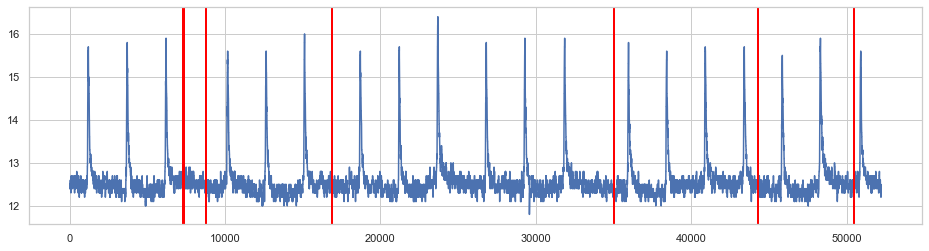

In [83]:
def plot_change_points(ts3,ts_change_loc1):
    plt.figure(figsize=(16,4))
    plt.plot(ts2)
    for x in ts_change_loc1:
        plt.axvline(x,lw=2, color='red')
            
plot_change_points(ts2,ts_change_loc1)

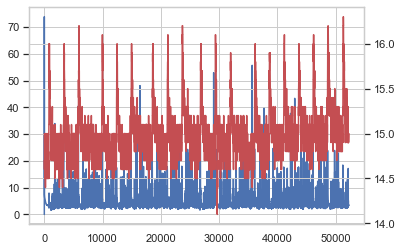

In [70]:
# -*- coding: utf-
import matplotlib.pyplot as plt
import changefinder
import numpy as np
#data=np.concatenate([np.random.normal(0.7, 0.05, 300),
#np.random.normal(1.5, 0.05, 300),
#np.random.normal(0.6, 0.05, 300),
#np.random.normal(1.3, 0.05, 300)])
data=ts3

cf = changefinder.ChangeFinder(r=0.01, order=1, smooth=3)

ret = []
for i in data:
    score = cf.update(i)
    ret.append(score)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ret)
ax2 = ax.twinx()
ax2.plot(data,'r')
plt.show()

In [71]:
ts_change_loc1 = pd.Series(ret).nlargest(20)
ts_change_loc1 = ts_change_loc1.index
ts_change_loc1

Int64Index([    5, 35682, 29072, 16422, 16423, 35681, 42982, 35683, 29073,
            29071,  5842, 37722, 42983, 42272, 24972, 48545, 16424,  5843,
            42273, 37723],
           dtype='int64')

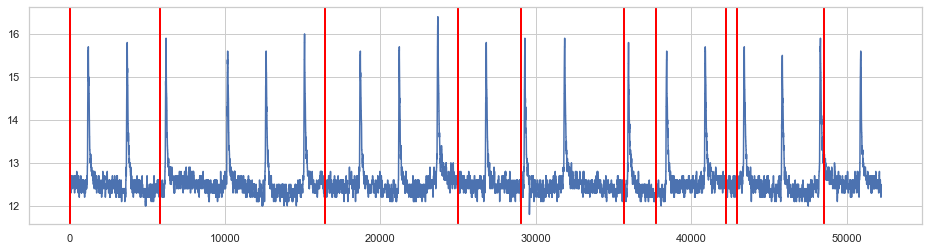

In [72]:
def plot_change_points(ts3,ts_change_loc1):
    plt.figure(figsize=(16,4))
    plt.plot(ts2)
    for x in ts_change_loc1:
        plt.axvline(x,lw=2, color='red')
            
plot_change_points(ts2,ts_change_loc1)

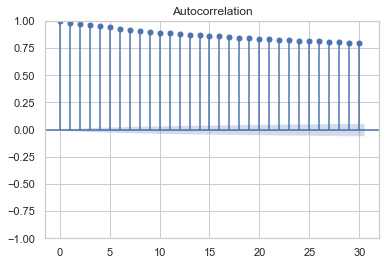

In [59]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# keeping lag as 30
plot_acf(ts3, lags=30);

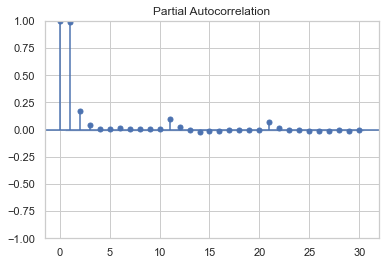

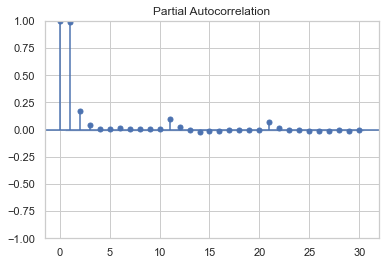

In [62]:
# plot pacf
plot_pacf(ts1, lags=30)

In [3]:
pip install changefinder

Note: you may need to restart the kernel to use updated packages.


In [4]:
 pip install statsmodels --upgrade

  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.1
    Uninstalling statsmodels-0.13.1:
      Successfully uninstalled statsmodels-0.13.1
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\Subhadeep\\AppData\\Local\\Temp\\pip-uninstall-4rn8tyw8\\tsa\\_innovations.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

